In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Overview

This is a generalized notebook for computing grade statistics from the Ted Grade Center.

In [1]:
#The usual imports
import math
import glob
import os
from collections import OrderedDict

from pandas import read_csv
import numpy as np

from pymatgen.util.plotting import pretty_plot
from monty.string import remove_non_ascii

import seaborn as sns
import matplotlib.pyplot as plt

import datetime

%matplotlib inline

print("Last updated on %s" % datetime.datetime.today())

Last updated on 2019-02-26 17:50:50.463377


In [2]:
# Load data from exported CSV from Ted Full Grade Center. 
# Some sanitization is performed to remove non-ascii characters and cruft.

files = glob.glob(os.path.join(os.environ["CENG114GC"], "*.csv"))
latest = sorted(files)[-1]
d = read_csv(latest)
d.columns = [remove_non_ascii(c) for c in d.columns]
d.columns = [c.split("[")[0].strip().strip("\"") for c in d.columns]
d = d.fillna(0)

In [3]:
# Define lower grade cutoffs in terms of number of standard deviations from mean.
grade_cutoffs = OrderedDict()
grade_cutoffs["A+"] = 1.5
grade_cutoffs["A"] = 1.0
grade_cutoffs["A-"] = 0.75
grade_cutoffs["B+"] = 0.5
grade_cutoffs["B"] = 0
grade_cutoffs["B-"] = -0.5
grade_cutoffs["C+"] = -0.75
grade_cutoffs["C"] = -1
grade_cutoffs["C-"] = -1.5
grade_cutoffs["F"] = float("-inf")

print("The cutoffs are:")
for k, v in grade_cutoffs.items():
    print(u"%s: > μ + %.2f σ" % (k, v))

The cutoffs are:
A+: > μ + 1.50 σ
A: > μ + 1.00 σ
A-: > μ + 0.75 σ
B+: > μ + 0.50 σ
B: > μ + 0.00 σ
B-: > μ + -0.50 σ
C+: > μ + -0.75 σ
C: > μ + -1.00 σ
C-: > μ + -1.50 σ
F: > μ + -inf σ


In [4]:
# Define some general functions for computing grade statistics.

def bar_plot(dframe, data_key, offset=0, annotate=True, cutoffs=None):
    """
    Creates a historgram of the results.
    
    Args:
        dframe: DataFrame which is imported from CSV.
        data_key: Specific column to plot
        offset: Allows an offset for each grade. Defaults to 0.
        
    Returns:
        dict of cutoffs, {grade: (lower, upper)}
    """
    data = dframe[data_key]
    d = [d for d in data if (not np.isnan(d)) and d != 0]
    heights, bins = np.histogram(d, bins=20, range=(0, 100))
    import matplotlib.pyplot as plt
    sns.distplot(d, bins=np.arange(0, 105, 5), kde=False, rug=True)
    plt = pretty_plot(12, 8, plt)
    plt.xlabel("Score")
    plt.ylabel("Number of students")
    mean = np.mean(d)
    sigma = np.std(d)
    maxy = np.max(heights) + 5
    prev_cutoff = 100
    if cutoffs is None:
        cutoffs = {}
        grade = ["A", "B+", "B", "B-", "C+", "C", "C-", "F"]
        for grade, cutoff in grade_cutoffs.items():
            if cutoff == float("-inf"):
                cutoff = 0
            else:
                cutoff = max(0, mean + cutoff * sigma) + offset
                if annotate:
                    plt.plot([cutoff] * 2, [0, maxy], 'k--')
                    plt.annotate("%.2f" % cutoff, [cutoff, maxy - 1], fontsize=18, horizontalalignment='left', rotation=45)
            n = len([d for d in data if cutoff <= d < prev_cutoff])
            #print "Grade %s (%.1f-%.1f): %d" % (grade, cutoff, prev_cutoff, n)
            if annotate:
                plt.annotate(grade, [(cutoff + prev_cutoff) / 2, maxy], fontsize=18, horizontalalignment='center')
            cutoffs[grade] = (cutoff, prev_cutoff)
            prev_cutoff = cutoff
    else:
        cutoffs = {k: (v[0] + offset, v[1] + offset) for k, v in cutoffs.items()}
        for grade, cutoff in cutoffs.items():
            if annotate:
                plt.plot([cutoff[0]] * 2, [0, maxy], 'k--')
                plt.annotate("%.2f" % cutoff[0], [cutoff[0], maxy - 1], fontsize=18, horizontalalignment='left', rotation=45)
                plt.annotate(grade, [(cutoff[0] + cutoff[1]) / 2, maxy], fontsize=18, horizontalalignment='center')
    plt.xlim([0, 100])
    plt.ylim([0, maxy * 1.1])
    plt.annotate('$\\mu = %.2f$\n$\\sigma = %.2f$\n$max=%.2f$' % (mean, sigma, data.max()), xy=(10, 7), fontsize=30)
    title = data_key.split("[")[0].strip()
    plt.title(title, fontsize=30)
    plt.tight_layout()
    # plt.savefig("%s.png" % title)
    return cutoffs


def assign_grades(d, column_name, cutoffs):
    def compute_grade(pts):
        for g, c in cutoffs.items():
            if c[0] < pts <= c[1]:
                return g

    d["Final_Assigned_Egrade"] = [compute_grade(v) for v in d[column_name]]
    d.to_csv(os.path.join(os.path.join(os.environ["CENG114GC"], "Overall grades %s.csv" % datetime.datetime.today().date())))

# Problem Sets

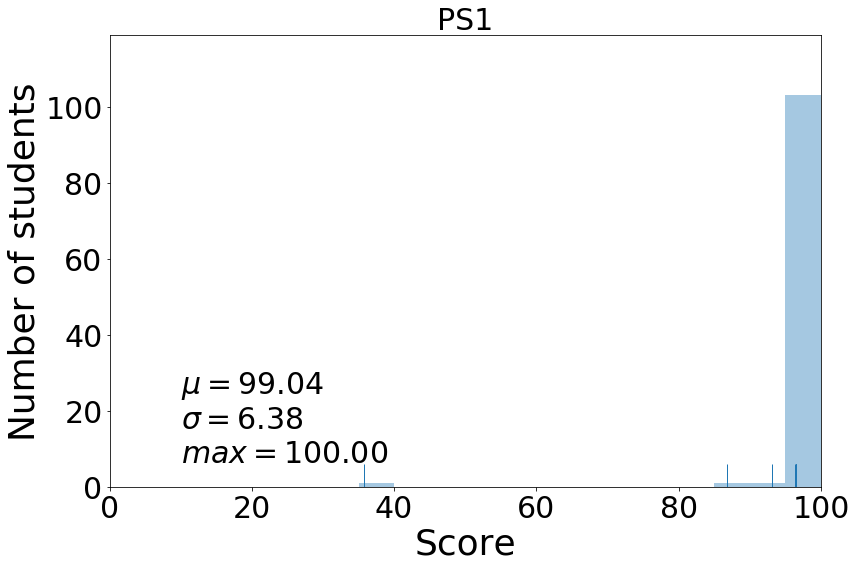

In [5]:
cutoffs = bar_plot(d, "PS1", annotate=False)

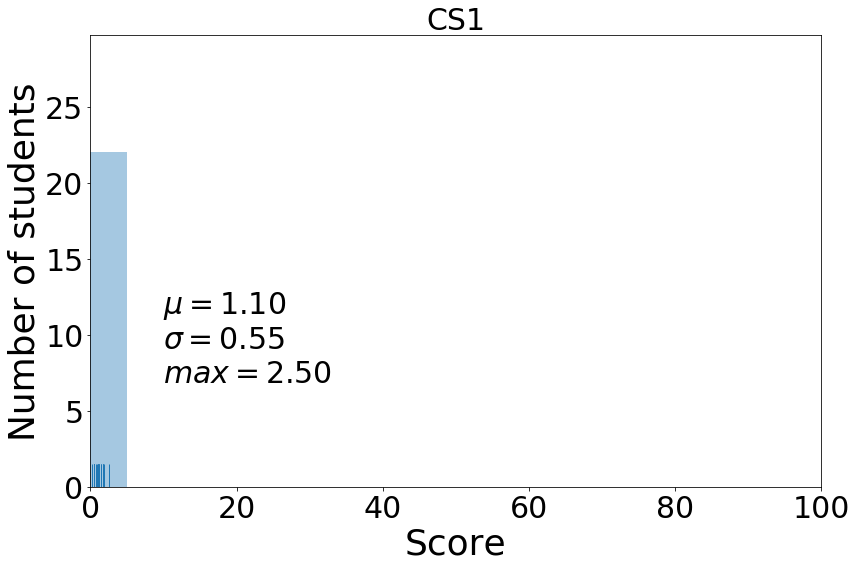

In [6]:
cutoffs = bar_plot(d, "CS1", annotate=False)

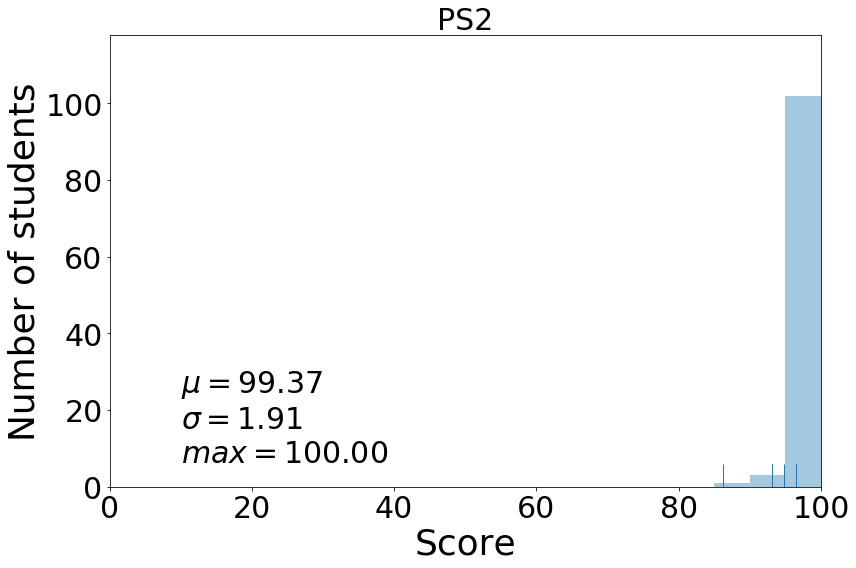

In [9]:
cutoffs = bar_plot(d, "PS2", annotate=False)

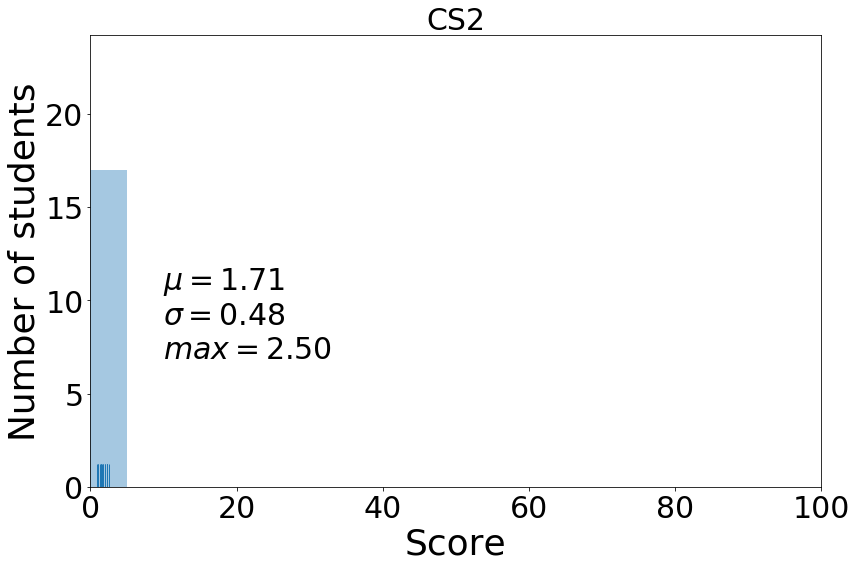

In [10]:
cutoffs = bar_plot(d, "CS2", annotate=False)

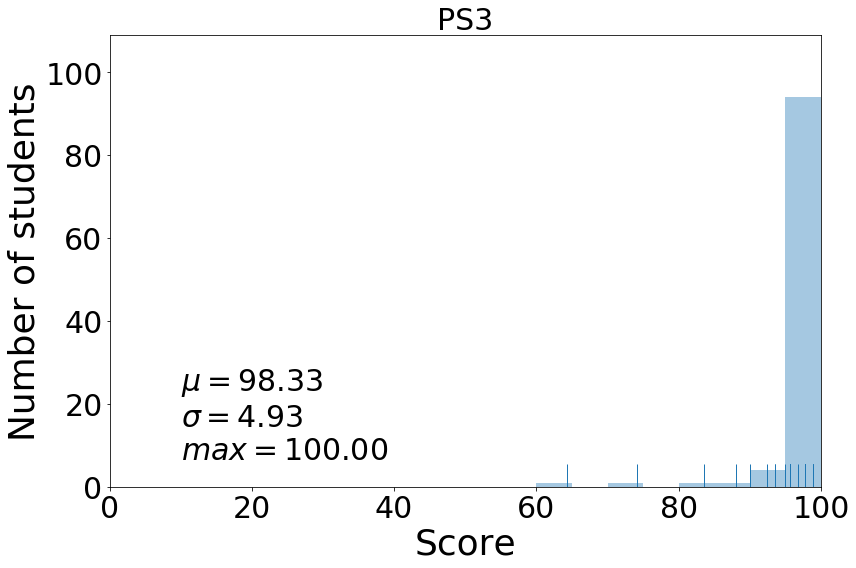

In [11]:
cutoffs = bar_plot(d, "PS3", annotate=False)

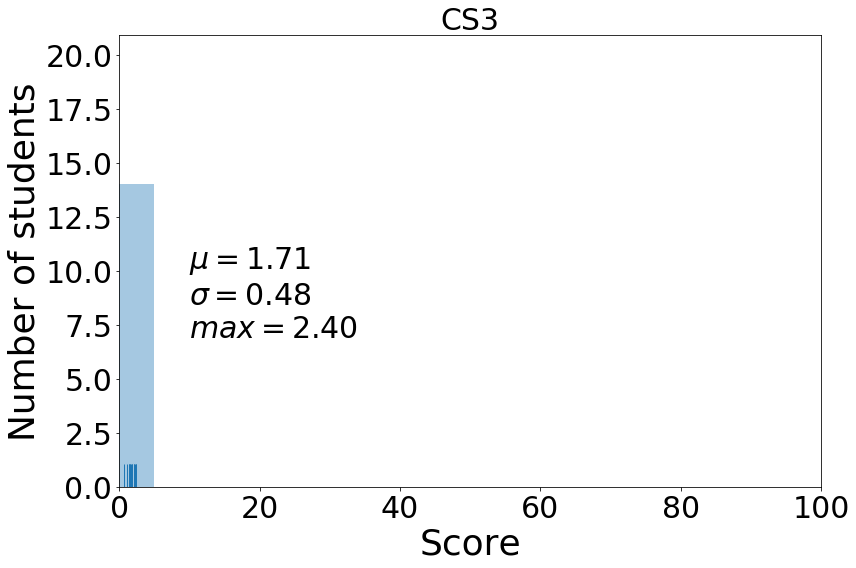

In [12]:
cutoffs = bar_plot(d, "CS3", annotate=False)

In [12]:
# cutoffs = bar_plot(d, "PS4", annotate=False)

In [13]:
# cutoffs = bar_plot(d, "CS4", annotate=False)

In [14]:
# cutoffs = bar_plot(d, "PS5", annotate=False)

In [15]:
# cutoffs = bar_plot(d, "CS5", annotate=False)

# Exams

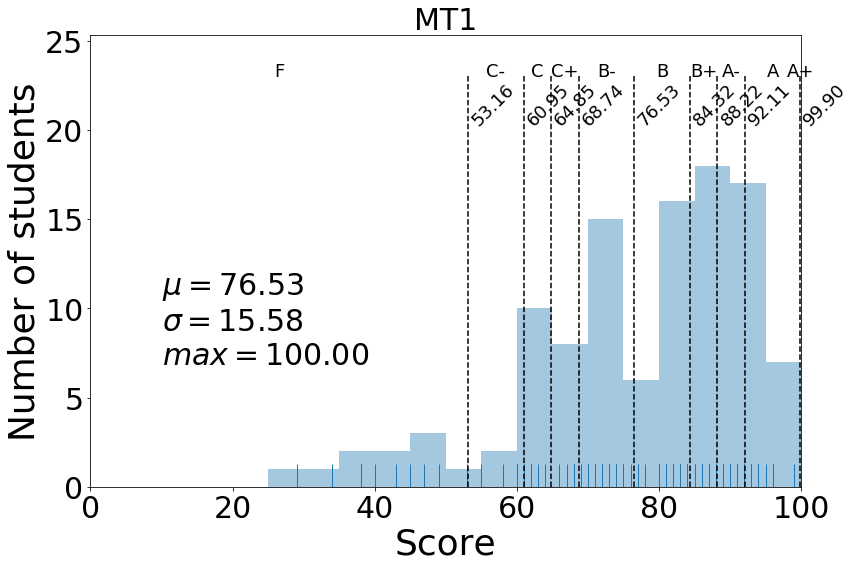

In [13]:
cutoffs = bar_plot(d, "MT1", annotate=True)

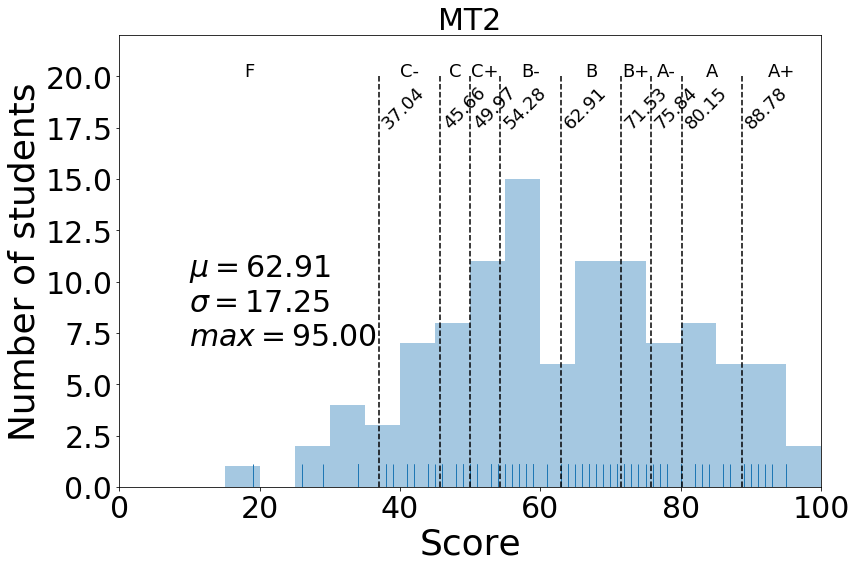

In [14]:
cutoffs = bar_plot(d, "MT2", annotate=True)

In [18]:
# cutoffs = bar_plot(d, "Final", annotate=True)

# Overall grade

In [19]:
# cutoffs = bar_plot(d, "Weighted Total", annotate=True)

In [20]:
# cutoffs = bar_plot(d, "Final Total", offset=-1.93548, cutoffs=cutoffs, annotate=True)

In [21]:
# The command below is used to generate the overall grade assignments for all students and dump it into a CSV file.
# assign_grades(d, "Final Total", cutoffs=cutoffs)